# Starting glider data analysis

In [1]:
import utils

### 1. Get a list of datasets of interest

One can make of glider-mission combinations by examining maps and figures from the [observations portal](https://observations.voiceoftheocean.org/), which can then be matched to dataset IDs (see [glider_data_download notebook](https://github.com/voto-ocean-knowledge/download_glider_data/blob/main/glider_data_download.ipynb) in this repo). Alternatively, one can programatically interogate the ERDDAP itself to find datasets that match certain criteria ([metatadata_dig notebook in this repo](https://github.com/voto-ocean-knowledge/download_glider_data/blob/main/metadata_dig.ipynb)).

Either way, you end up with a list of datasetIDs like this:



In [2]:
datasets_to_download = ['delayed_SEA068_M27', 'nrt_SEA068_M27', 'delayed_SEA069_M9',
       'nrt_SEA069_M9', 'delayed_SEA067_M26', 'nrt_SEA067_M26',
       'delayed_SEA067_M27', 'nrt_SEA067_M27', 'delayed_SEA067_M29',
       'nrt_SEA067_M29', 'nrt_SEA067_M30', 'delayed_SEA066_M41',
       'nrt_SEA066_M41', 'nrt_SEA066_M42']

These are datasets that extended to > 150 m depth in the seas northeast of Gotland

### 2. Quick check with nrt datasets

For preliminary analysis, I recommend downloading only the NRT (near real time) datasets, as these are ~ 100 times smaller than the delayed mode data and are much quicker to work with. To achieve this, we use the `nrt_only=True` kwarg

In [3]:
ds_dict = utils.download_glider_dataset(datasets_to_download, nrt_only=True)

delayed_SEA068_M27 is not nrt. Ignoring
delayed_SEA069_M9 is not nrt. Ignoring
delayed_SEA067_M26 is not nrt. Ignoring
delayed_SEA067_M27 is not nrt. Ignoring
delayed_SEA067_M29 is not nrt. Ignoring
delayed_SEA066_M41 is not nrt. Ignoring


This function returns a dictionary where the keys are dataset IDs and the values are the datasets as xarray objects

In [4]:
ds_dict["nrt_SEA068_M27"]

<xarray.Dataset>
Dimensions:                (timeseries: 73, obs: 4052)
Coordinates:
    latitude               (obs) float64 ...
    longitude              (obs) float64 ...
    time                   (obs) datetime64[ns] ...
    depth                  (obs) float64 ...
Dimensions without coordinates: timeseries, obs
Data variables: (12/37)
    profile_index          (timeseries) float64 ...
    rowSize                (timeseries) int32 ...
    angular_cmd            (obs) float64 ...
    angular_pos            (obs) float64 ...
    backscatter            (obs) float64 ...
    backscatter_raw        (obs) float64 ...
    ...                     ...
    distance_over_ground   (obs) float64 ...
    profile_direction      (obs) float64 ...
    potential_density      (obs) float64 ...
    density                (obs) float64 ...
    potential_temperature  (obs) float64 ...
    profile_num            (obs) float64 ...
Attributes: (12/72)
    acknowledgement:               This study used data collected and made fr...
    basin:                         Eastern Gotland Basin
    cdm_data_type:                 TimeSeries
    cdm_timeseries_variables:      profile_index
    comment:                       deployment and recovery in Skagerrak
    contributor_name:              Callum Rollo, Louise Biddle, Olle Petersso...
    ...                            ...
    time_coverage_end:             2022-07-31T02:47:09Z
    time_coverage_start:           2022-07-27T17:09:41Z
    title:                         Aster68-20220727T1709
    transmission_system:           IRIDIUM
    Westernmost_Easting:           19.901883333333334
    wmo_id:                        6801602

### 3. Initial analysis

Here we will create some quick plots to check that the datasets have what we need

In [5]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import style
style.use('presentation.mplstyle')
import cartopy
import cartopy.crs as ccrs
import gsw

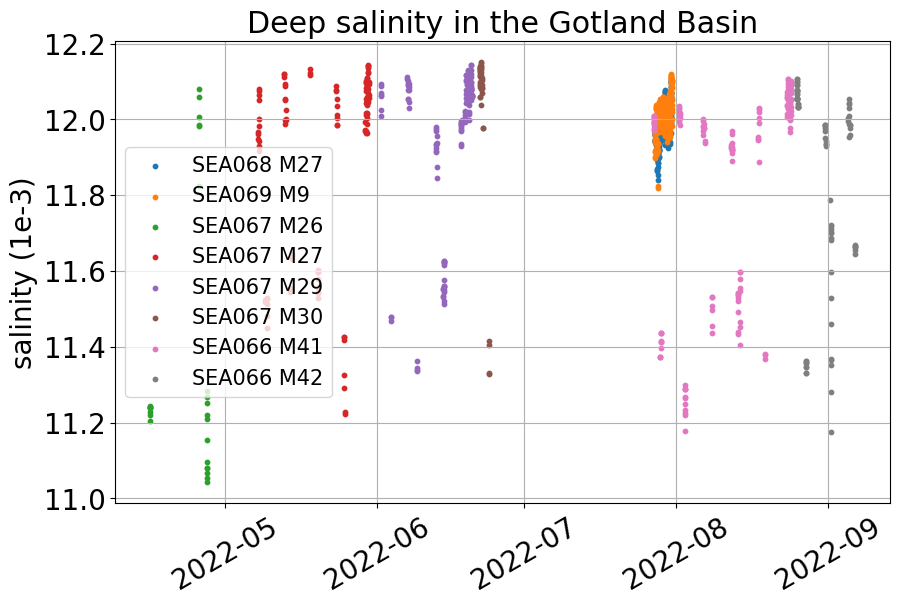

In [6]:
min_depth = 140
fig, ax = plt.subplots(figsize=(10, 6))
for name, ds in ds_dict.items():
    pretty_label = f'SEA0{ds.attrs["glider_serial"]} M{ds.attrs["deployment_id"]}'
    ax.scatter(ds.time[ds.depth> min_depth], ds.salinity[ds.depth> min_depth], label=pretty_label, s=10)
ax.legend()
plt.setp(ax.get_xticklabels(), rotation=30);
ax.set(ylabel=f"{ds.salinity.name} ({ds.salinity.units})", title="Deep salinity in the Gotland Basin")
plt.grid()

A small map of the area

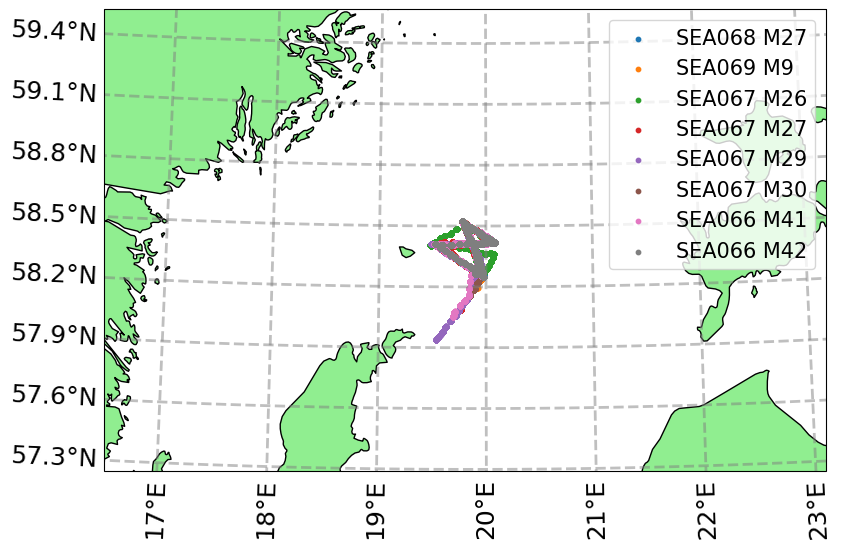

In [7]:
coord = cartopy.crs.AzimuthalEquidistant(central_longitude=np.mean(ds.longitude.values),
                                  central_latitude=np.mean(ds.latitude.values))
pc = cartopy.crs.PlateCarree()
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection=coord)

for name, ds in ds_dict.items():
    pretty_label = f'SEA0{ds.attrs["glider_serial"]} M{ds.attrs["deployment_id"]}'
    ax.scatter(ds.longitude.values, ds.latitude.values, transform=pc, s=10, label=pretty_label)
lon_extend = 3
lat_extend = 1
lims = (np.nanmin(ds.longitude.values) - lon_extend, np.nanmax(ds.longitude.values) + lon_extend,
        np.nanmin(ds.latitude.values) - lat_extend, np.nanmax(ds.latitude.values) + lat_extend)
ax.set_extent(lims, crs=pc)

feature = cartopy.feature.NaturalEarthFeature(name='land', category='physical',
                                       scale='10m', edgecolor='black', facecolor='lightgreen')
ax.add_feature(feature)
gl = ax.gridlines(draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = None
gl.right_labels = None
ax.legend()

Maybe there's a geographical gradient at play too? There appears to be a bimodal distribution of salinity. Rather than a timeseries, let's plot against latitude

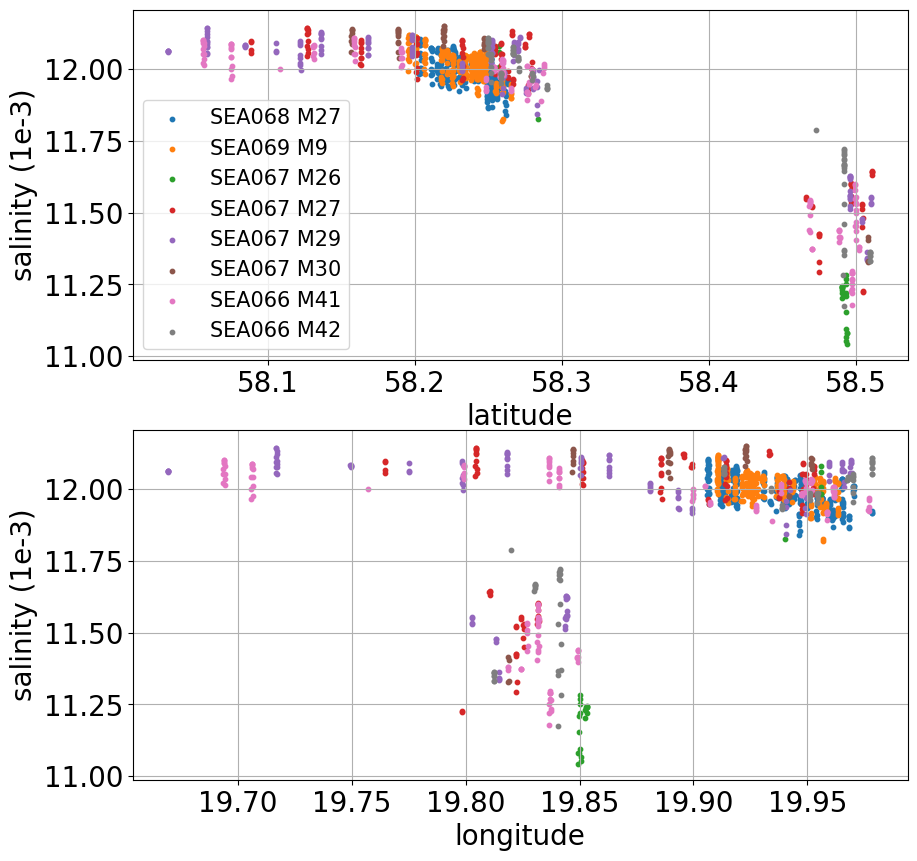

In [8]:
fig, (ax0, ax1) = plt.subplots(2,1, figsize=(10, 10))
for name, ds in ds_dict.items():
    pretty_label = f'SEA0{ds.attrs["glider_serial"]} M{ds.attrs["deployment_id"]}'
    ax0.scatter(ds.latitude[ds.depth> min_depth], ds.salinity[ds.depth> min_depth], label=pretty_label, s=10)
    ax1.scatter(ds.longitude[ds.depth> min_depth], ds.salinity[ds.depth> min_depth], label=pretty_label, s=10)
ax0.legend()
plt.setp(ax.get_xticklabels(), rotation=30);
ax0.set(ylabel=f"{ds.salinity.name} ({ds.salinity.units})", xlabel="latitude")
ax1.set(ylabel=f"{ds.salinity.name} ({ds.salinity.units})", xlabel="longitude")
ax0.grid()
ax1.grid()

There's definitely some spatial vartiability here. Maybe a seperare sub-basin to the southeast? Let's subset our data a bit before plotting it

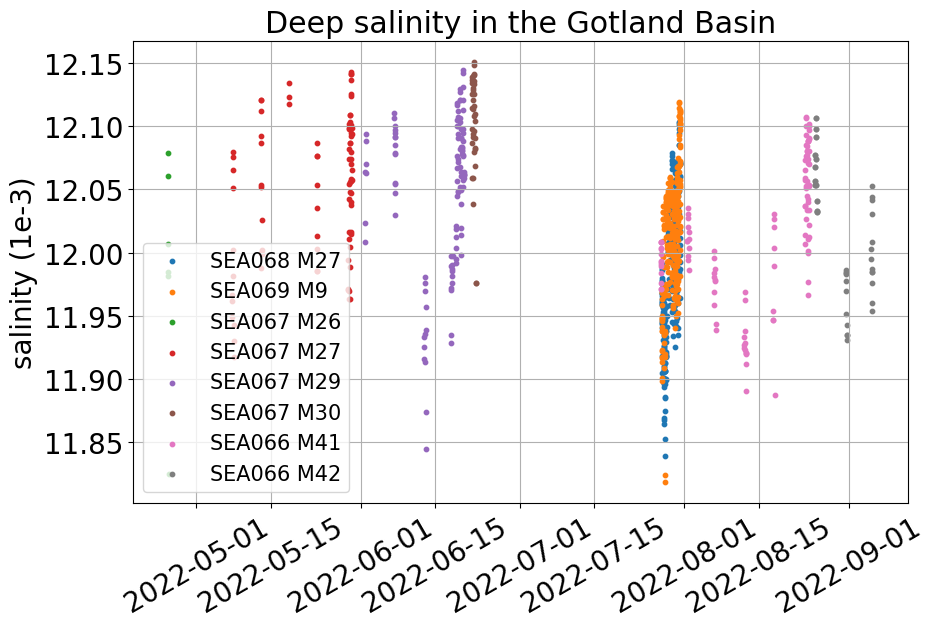

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))
for name, ds in ds_dict.items():
    pretty_label = f'SEA0{ds.attrs["glider_serial"]} M{ds.attrs["deployment_id"]}'
    mask = (ds.depth.values > min_depth) * (ds.latitude.values<58.4)
    ax.scatter(ds.time[mask], ds.salinity[mask], label=pretty_label, s=10)
ax.legend()
plt.setp(ax.get_xticklabels(), rotation=30);
ax.set(ylabel=f"{ds.salinity.name} ({ds.salinity.units})", title="Deep salinity in the Gotland Basin")
plt.grid()

### 4. Download the full datasets

Once we are confident that the dataset contain something of interest, we can download the full size delayed mode datasets. This uses a cache of data in the directory `voto_erddap_data_cache` to avoid duplicate downloads.

**To force data to re-download, simply delete the cache dir**

In [10]:
ds_delayed = utils.download_glider_dataset(datasets_to_download, delayed_only=True)

nrt_SEA068_M27 is not delayed. Ignoring
nrt_SEA069_M9 is not delayed. Ignoring
nrt_SEA067_M26 is not delayed. Ignoring
nrt_SEA067_M27 is not delayed. Ignoring
nrt_SEA067_M29 is not delayed. Ignoring
nrt_SEA067_M30 is not delayed. Ignoring
nrt_SEA066_M41 is not delayed. Ignoring
nrt_SEA066_M42 is not delayed. Ignoring
Found voto_erddap_data_cache/delayed_SEA068_M27.nc. Loading from disk
Found voto_erddap_data_cache/delayed_SEA069_M9.nc. Loading from disk
Found voto_erddap_data_cache/delayed_SEA067_M26.nc. Loading from disk
Found voto_erddap_data_cache/delayed_SEA067_M27.nc. Loading from disk
Found voto_erddap_data_cache/delayed_SEA067_M29.nc. Loading from disk
Found voto_erddap_data_cache/delayed_SEA066_M41.nc. Loading from disk


To demonstrate, here I delete one of the cached datasets then call the download function again

In [11]:
!rm voto_erddap_data_cache/delayed_SEA069_M9.nc
ds_delayed = utils.download_glider_dataset(datasets_to_download, delayed_only=True)

nrt_SEA068_M27 is not delayed. Ignoring
nrt_SEA069_M9 is not delayed. Ignoring
nrt_SEA067_M26 is not delayed. Ignoring
nrt_SEA067_M27 is not delayed. Ignoring
nrt_SEA067_M29 is not delayed. Ignoring
nrt_SEA067_M30 is not delayed. Ignoring
nrt_SEA066_M41 is not delayed. Ignoring
nrt_SEA066_M42 is not delayed. Ignoring
Found voto_erddap_data_cache/delayed_SEA068_M27.nc. Loading from disk
Writing voto_erddap_data_cache/delayed_SEA069_M9.nc
Found voto_erddap_data_cache/delayed_SEA067_M26.nc. Loading from disk
Found voto_erddap_data_cache/delayed_SEA067_M27.nc. Loading from disk
Found voto_erddap_data_cache/delayed_SEA067_M29.nc. Loading from disk
Found voto_erddap_data_cache/delayed_SEA066_M41.nc. Loading from disk


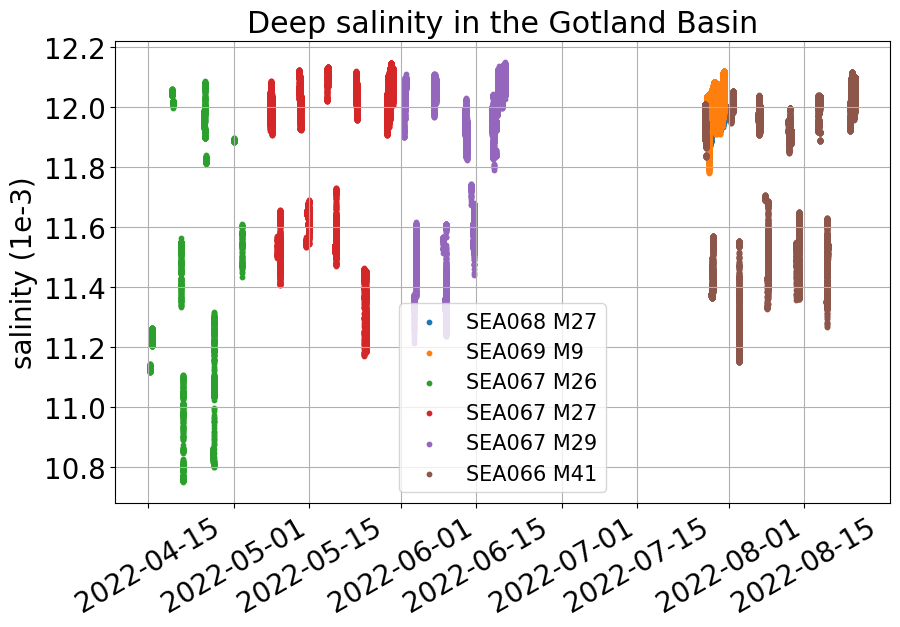

In [12]:
min_depth = 140
fig, ax = plt.subplots(figsize=(10, 6))
for name, ds in ds_delayed.items():
    pretty_label = f'SEA0{ds.attrs["glider_serial"]} M{ds.attrs["deployment_id"]}'
    ax.scatter(ds.time[ds.depth> min_depth], ds.salinity[ds.depth> min_depth], label=pretty_label, s=10)
ax.legend()
plt.setp(ax.get_xticklabels(), rotation=30);
ax.set(ylabel=f"{ds.salinity.name} ({ds.salinity.units})", title="Deep salinity in the Gotland Basin")
plt.grid()

Using the delayed mode datasets we have data at much higher temporal resolution, but we lack the most up to date data, as we need to physically recover the gliders to get the delayed mode data

### 5. Combine datasets

from the [VOTO stats page](https://observations.voiceoftheocean.org/stats) we see that SEA067 completed three back to back missions in the Gotland basin during April - June 2022

![observations gantt plot](https://observations.voiceoftheocean.org/static/img/glider/gantt_all_ops.png)

Using this information, we can be confident in combining those missions (M26, M27, M29) into one dataset:

In [13]:
def add_profile_time(ds):
    profile_num = ds.pressure.copy()
    profile_num.attrs = {}
    profile_num.name = "profile_num"
    profile_num[:] = 0
    start = 0
    for i, prof_index in enumerate(ds.profile_index):
        rowsize = ds.rowSize.values[i]
        profile_num[start:start+rowsize] = prof_index
        start = start + rowsize
    ds["profile_num"] = profile_num
    profile_time = ds.time.values.copy()
    profile_index = ds.profile_num
    for profile in np.unique(profile_index.values):
        mean_time = ds.time[profile_index==profile].mean().values
        new_times = np.empty((len(ds.time[profile_index==profile])), dtype='datetime64[ns]')
        new_times[:] = mean_time
        profile_time[profile_index==profile] = new_times
    profile_time_var = ds.time.copy()
    profile_time_var.values = profile_time
    profile_time_var.name="profile_mean_time"
    ds["profile_mean_time"] = profile_time_var
    ds = ds.drop_dims("timeseries")
    return ds

In [14]:
# note, we have to do some dimenstion wrangling to coerce the ncs together in a way that GliderTools will like.
# This hack should be made redundant with future changes to the data processing chain
ds_m26 = utils.add_profile_time(ds_delayed["delayed_SEA067_M26"])
ds_m27 = utils.add_profile_time(ds_delayed["delayed_SEA067_M27"])
ds_m29 = utils.add_profile_time(ds_delayed["delayed_SEA067_M29"])
ds_gotland = xr.concat((ds_m26, ds_m27, ds_m29), dim='obs')

We can now create plots from one dataset, rather than looping through several individual ones

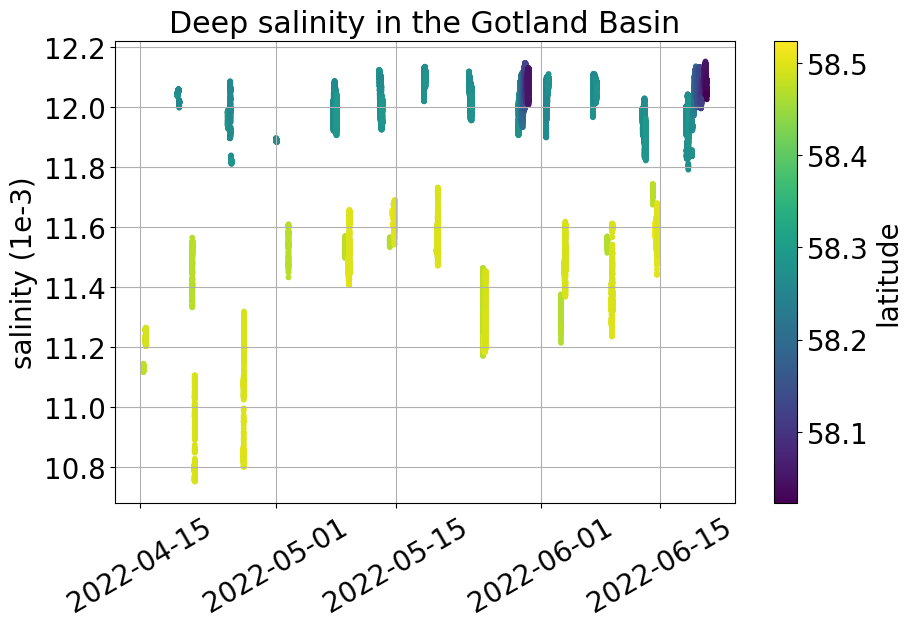

In [15]:
min_depth = 140
fig, ax = plt.subplots(figsize=(10, 6))

col = ax.scatter(ds_gotland.time[ds_gotland.depth> min_depth], ds_gotland.salinity[ds_gotland.depth> min_depth], c=ds_gotland.latitude[ds_gotland.depth> min_depth],s=10)
plt.setp(ax.get_xticklabels(), rotation=30);
fig.colorbar(ax=ax, mappable=col, label="latitude")
ax.set(ylabel=f"{ds.salinity.name} ({ds.salinity.units})", title="Deep salinity in the Gotland Basin")
plt.grid()

### 6. GliderTools

[glidertools](https://github.com/GliderToolsCommunity/GliderTools) is a collaborative toolbox for post processing glider data. It has some nice flagging/smoothing functionality, inbuilt plotting and the capacbility to calculate secondary variables like mixed layer depth.

In [16]:
import glidertools as gt
from cmocean import cm as cmo 
%load_ext autoreload
# pylab for more MATLAB like environment and inline displays plots below cells 
%pylab inline
plt.rcParams.update({'font.size': 14})

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


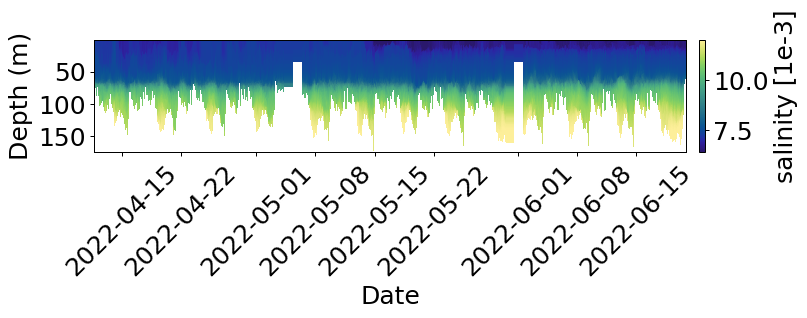

In [17]:
gt.plot(ds_gotland.profile_mean_time, ds_gotland.depth, ds_gotland.salinity, cmap=cmo.haline, robust=True)
show()

Check out more GliderTools functionality in their [demo notebook](https://github.com/GliderToolsCommunity/GliderTools/blob/master/notebooks/Demo_GT.ipynb)

------------------------

# Miscellaneous tips

- To save time and avoid reprocessing from scratch each time, you can always save your xarray dataset with `ds.to_netcdf("/path/filename.nc")` and load it back in with `ds = xr.open_dataset("/path/filename.nc")`. *However* ensure that your workflow can recreate your results from the data download onward, so that any changes to the orginal datasets (more data in NRT, better QC etc.) can be incorporated into your analysis
- Save figures with `fig.savefig("figures/fig_name.png")`
- You can save download time and disk space by downloading only the variables you need. Pass them as a list to `utils.download_glider_dataset`
- To force a re-run from fresh data, delete the `voto_erddap_data_cache` directory